<a href="https://colab.research.google.com/github/khankaleem/Generating-fake-faces/blob/main/celebA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir('/gdrive/My Drive/gan0')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# **Visualize CelebA Dataset**

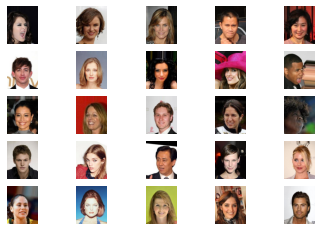

In [ ]:
from os import listdir
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

def loadImage(fName):
  return asarray(Image.open(fName).convert('RGB'))
 
def loadFaces(directory, nFaces):
  faces = list()
  for fname in listdir(directory):
    faces.append(loadImage(directory + fname))
    if len(faces) >= nFaces:
      break
  return asarray(faces)
 
def plotFaces(faces, n):
  for i in range(n ** 2):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(faces[i])
  pyplot.show()

plotFaces(loadFaces('/gdrive/My Drive/gan0/img_align_celeba/', 25),5)

INSTALL MTCNN FOR FACE DETECTION

In [ ]:
!pip install mtcnn

In [ ]:
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from datetime import datetime
now = datetime.now()

def loadImage(fName):
  return asarray(Image.open(fName).convert('RGB'))

def getFace(model, pixels, dim = (80, 80)):
	faces = model.detect_faces(pixels)
	if len(faces) == 0:
		return None
	x1, y1, w, h = faces[0]['box']
	x1 = abs(x1)
	y1 = abs(y1)
	x2 = abs(x1) + w
	y2 = abs(y1) + h
	face_pixels = pixels[y1:y2, x1:x2]
	return asarray(Image.fromarray(pixels[y1:y2, x1:x2]).resize(dim))

def loadFaces(dir, nFaces):
	model = MTCNN()
	faces = list()
	for fname in listdir(dir):
		pixels = loadImage(dir + fname)
		face = getFace(model, pixels)
		if face is None:
			continue
		faces.append(face)
		if len(faces) % 500 == 0:
			global now
			print(len(faces), (datetime.now()-now).seconds)
			now = datetime.now()
		if len(faces) >= nFaces:
			break
	return asarray(faces)

faces = loadFaces('img_align_celeba/', 50000)
print('Loaded: ', faces.shape)
savez_compressed('extracted_faces_celeba.npz', faces)

# **Extracted** Faces

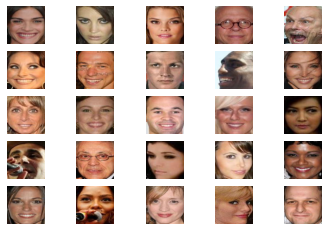

In [ ]:
from numpy import load
plotFaces(load('/gdrive/My Drive/gan0/extracted_faces_celeba.npz')['arr_0'], 5)

# **Train**

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
"""
Define discriminator model
"""
def Discriminator(input_shape = (80,80,3)):
	model = Sequential()
	model.add(Conv2D(128, (5,5), padding='same', input_shape=input_shape))

	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))

	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

"""
Define Generator model
"""
def Generator(spatial_dim):
	model = Sequential()

	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=spatial_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model
 
"""
Define GAN Model
"""
def GAN(gen, dis):
	d.trainable = False
	model = Sequential()
	model.add(gen)
	model.add(dis)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
"""
Load dataset
"""
def loadData():
	data = load('/gdrive/My Drive/gan0/extracted_faces_celeba.npz')['arr_0'].astype('float32')
	data = (data - 127.5) / 127.5
	return data

"""
generate real data samples from dataset
"""
def generateRealSamples(dataset, n_samples):
	i = randint(0, dataset.shape[0], n_samples)
	X = dataset[i]
	y = ones((n_samples, 1))
	return X, y
 
"""
generate latent points in space
"""
def generateLatentPoints(spatial_dim, n_samples):
	x_input = randn(spatial_dim * n_samples)
	x_input = x_input.reshape(n_samples, spatial_dim)
	return x_input
 
"""
generate fake images using generator from latent points
"""
def generateFakeSamples(g_model, spatial_dim, n_samples):
	x_input = generateLatentPoints(spatial_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

"""
save fake images generated
"""
def savePlot(examples, epoch, n = 5):
  #scale
  examples = (examples + 1) / 2.0
  #plot
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])
  #save image
  fname = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(fname)
  pyplot.close()
 
"""
summarize the accuracy of discrimator on fake and real samples
save fake generated
"""
def summarizePerformance(epoch, g_model, d_model, dataset, spatial_dim, n_samples=100):
	#evaluate discrimator on real samples
  X_real, y_real = generateRealSamples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  #evaluate discriminator on fake samples
  x_fake, y_fake = generateFakeSamples(g_model, spatial_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  #print accuracy
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  #save plot
  savePlot(x_fake, epoch)
  #save model
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)
 
"""
Train the GAN model
train discriminator first
train generator on the loss of discrimator
"""
def train(g_model, d_model, gan_model, dataset, spatial_dim, n_epochs=30, n_batch=128):
		dloss = []
		gloss = []
		#get batches per epoch
		batches_per_epoch = int(dataset.shape[0] / n_batch)
		#get half batch size
		half_batch = n_batch // 2

		for i in range(n_epochs):
			for j in range(batches_per_epoch):
				#get real data
				X_real, y_real = generateRealSamples(dataset, half_batch)
				#train discriminator on real data
				d_loss1, _ = d_model.train_on_batch(X_real, y_real)
				#get fake data
				X_fake, y_fake = generateFakeSamples(g_model, spatial_dim, half_batch)
				#train discriminator on fake data
				d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
				#train generator on the error of discriminator
				X_gan = generateLatentPoints(spatial_dim, n_batch)
				y_gan = ones((n_batch, 1))
				g_loss = gan_model.train_on_batch(X_gan, y_gan)
				if (j+1)%130 == 0:
					dloss.append(d_loss1 + d_loss2)
					gloss.append(g_loss)
					print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, batches_per_epoch, d_loss1, d_loss2, g_loss))
			#summarize performance every 10 epochs
			if i == 0 or i == 4 or (i+1)%10 == 0:
				summarizePerformance(i, g_model, d_model, dataset, spatial_dim)
		return dloss, gloss
#initialize the number of dimensions
spatial_dim = 100
#initialize the discriminator model
d = Discriminator()
#initialize the generator model
g = Generator(spatial_dim)
#initilaize the GAN model
gan = GAN(g, d)
#load dataset
dataset = loadData()
#train the model
d_loss, g_loss = train(g, d, gan, dataset, spatial_dim)

>1, 130/390, d1=0.008, d2=0.000 g=10.900
>1, 260/390, d1=0.057, d2=0.029 g=4.558
>1, 390/390, d1=0.211, d2=0.262 g=3.284
>Accuracy real: 90%, fake: 100%
>2, 130/390, d1=0.789, d2=0.699 g=4.513
>2, 260/390, d1=3.058, d2=0.139 g=2.381
>2, 390/390, d1=0.195, d2=0.053 g=4.245
>3, 130/390, d1=3.620, d2=0.869 g=3.666
>3, 260/390, d1=0.164, d2=0.184 g=4.327
>3, 390/390, d1=0.311, d2=0.072 g=3.681
>4, 130/390, d1=0.183, d2=0.184 g=3.758
>4, 260/390, d1=0.683, d2=0.287 g=3.003
>4, 390/390, d1=0.287, d2=0.284 g=4.529
>5, 130/390, d1=0.334, d2=0.068 g=4.404
>5, 260/390, d1=0.199, d2=0.263 g=3.685
>5, 390/390, d1=0.262, d2=0.142 g=3.986
>Accuracy real: 92%, fake: 96%
>6, 130/390, d1=0.282, d2=0.273 g=4.546
>6, 260/390, d1=0.115, d2=0.204 g=3.737
>6, 390/390, d1=0.231, d2=0.393 g=3.651
>7, 130/390, d1=0.146, d2=0.094 g=4.400
>7, 260/390, d1=0.093, d2=0.191 g=4.607
>7, 390/390, d1=0.262, d2=0.372 g=4.330
>8, 130/390, d1=0.262, d2=0.232 g=3.345
>8, 260/390, d1=0.376, d2=0.605 g=4.353
>8, 390/390, d1=

# **Plot The Discriminator loss and the generator loss**

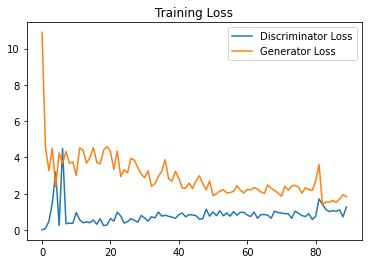

In [ ]:
import numpy as np
fig, ax = pyplot.subplots()
d_loss = np.array(d_loss)
g_loss = np.array(g_loss)
pyplot.plot(d_loss, label='Discriminator Loss')
pyplot.plot(g_loss, label='Generator Loss')
pyplot.title('Training Loss')
pyplot.legend()

# **Generate images by loading the saved generator model after 30 epochs**

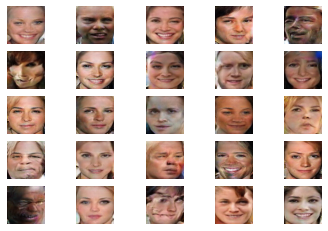

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# create a plot of generated images
def plot_generated(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_030.h5')
# generate points
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)